In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns 
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

2023-04-13 18:13:40.496575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('Resources_Clean/Result_Protein_Peptide_Combine.csv')

In [4]:
df.head()

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,On,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,...,62329,62437,62723,62732,62792,63875,63889,64669,64674,65043
0,0,10.0,6.0,15.0,0.0,0,8984260.0,53855.6,8579740.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,6,8.0,10.0,34.0,0.0,0,8279770.0,45251.9,8655890.0,49927.5,...,0,0,0,0,0,0,0,0,0,0
2,12,10.0,10.0,41.0,0.0,1,8382390.0,53000.9,8995640.0,45519.2,...,0,0,0,0,0,0,0,0,0,0
3,36,17.0,18.0,51.0,0.0,1,10671500.0,58108.4,9985420.0,52374.0,...,0,0,0,0,0,0,0,0,0,0
4,6,8.0,2.0,21.0,0.0,0,6177730.0,42682.6,3596660.0,25698.8,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df['sum_score'] = df[df.filter(regex = 'updrs').columns].sum(axis = 1)
df.drop(df.filter(regex = 'updrs').columns, axis = 1, inplace = True)

## Feature Selection

### Correlation 

In [12]:
corr_ = abs(df.corr()[['sum_score']])
corr_ = corr_.sort_values(by = 'sum_score', ascending = False)
corr_ = corr_[corr_.index != 'sum_score']

In [13]:
corr_.head()

,sum_score
On,0.265636
FIYGGC(UniMod_4)GGNR,0.240760
P43121,0.237267
TLKIENVSYQDKGNYR,0.234878
P17174,0.232606


In [23]:
corr_.describe()

,sum_score
count,1445.000000
mean,0.072024
std,0.052712
min,0.000066
25%,0.029188
50%,0.062829
75%,0.102504
max,0.265636


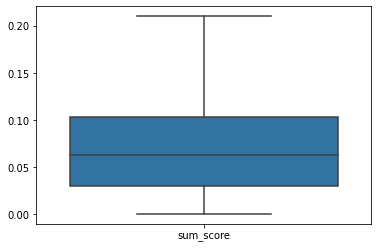

In [22]:
sns.boxplot(data = corr_, showfliers = False)
plt.show()

In [28]:
# Selection of correlated columns to Y. 
cut_off = [0.1, 0.06, 0]

corr_against_y = [corr_[corr_['sum_score'] > 0.1].index]

In [29]:
corr_against_y 

[Index(['On', 'FIYGGC(UniMod_4)GGNR', 'P43121', 'TLKIENVSYQDKGNYR', 'P17174',
        'Q06481', 'O15240', 'QQETAAAETETR', 'P05060', '40650',
        ...
        'P12109', 'IC(UniMod_4)ANVFC(UniMod_4)GAGR', 'LGADMEDVC(UniMod_4)GR',
        'GSFAC(UniMod_4)QC(UniMod_4)PPGYQK', 'P08123', 'SLNNQIETLLTPEGSR',
        'ELQQAVLHMEQR', 'Q02818', 'SEYPSIK', 'P07998'],
       dtype='object', length=382)]

### Co-Variance 

In [16]:
import numpy as np

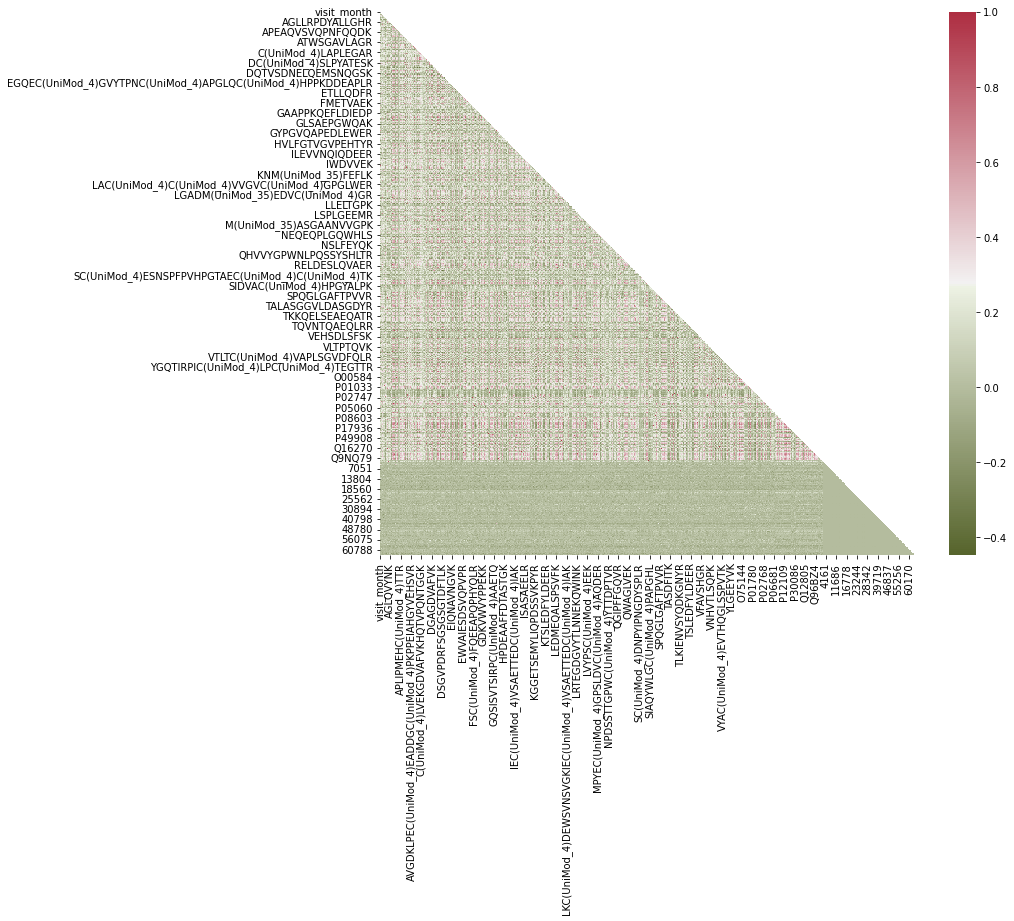

In [17]:
# HeatMap Creation 
cor = df.corr()

# Create a mask
mask = np.triu(np.ones_like(cor, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(12,10))

sns.heatmap(cor, mask=mask, cmap= cmap)

plt.show();

In [18]:
# Removal of Covariance Columns 
# Code snippet taken from krishnaik06 https://github.com/krishnaik06/Complete-Feature-Selection

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [19]:
corr_col = list()

for threshold in [0.6, 0.7, 0.8]:
    covariance = correlation(cor, threshold)
    columns = list(covariance)
    print(f'The number of covariant features is {len(columns)} with a threshold of {threshold}')
    corr_col.append(columns)

The number of covariant features is 1241 with a threshold of 0.6
The number of covariant features is 1182 with a threshold of 0.7
The number of covariant features is 1102 with a threshold of 0.8


In [6]:
# Getting X, Y columns 
y_col = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
x_col = [x for x in df.columns if x not in y_col]

# Splitting into X and Y 

X = df[x_col]
Y = df[y_col]

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

### Feature Selection 